# XGBoost classifier

In [1]:
# Change working directory to parent so we can import as we would from main.py
%cd ..

import itertools
from pickle import dump
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import KFold, cross_validate
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix, ConfusionMatrixDisplay

import classes.data as data_classes
import configuration as config

/mnt/arkk/llm_detector/classifier


## Off-the-shelf XGBoost classifier

In [2]:
# Instantiate the data class
data = data_classes.TrainTestData(
    training_data = config.COMBINED_SCORED_HANS_TRAINING_DATA_PR_TFIDF,
    testing_data = config.COMBINED_SCORED_HANS_TESTING_DATA_PR_TFIDF
)

scoring_metrics = ['neg_brier_score', 'neg_log_loss', 'accuracy']

# Cross validate the model
model = GradientBoostingClassifier()
kfold = KFold(n_splits = 10, shuffle = True, random_state = 7)

results = cross_validate(
    model, data.training.scale_features(), 
    data.training.encode_labels(), 
    scoring = scoring_metrics, 
    cv = kfold, 
    return_train_score = True
)


In [3]:
# Evaluate predictions
for scoring_metric, dataset in itertools.product(scoring_metrics, ['train', 'test']):

    metric_mean = round(results[f'{dataset}_{scoring_metric}'].mean(), 2)
    metric_stdev = round(results[f'{dataset}_{scoring_metric}'].std(), 3)

    print(f'CV {dataset} {scoring_metric}: {metric_mean:.2f} +/- {metric_stdev:.3f}')

CV train neg_brier_score: -0.08 +/- 0.000
CV test neg_brier_score: -0.08 +/- 0.002
CV train neg_log_loss: -0.25 +/- 0.000
CV test neg_log_loss: -0.25 +/- 0.004
CV train accuracy: 0.90 +/- 0.000
CV test accuracy: 0.89 +/- 0.002



Confusion matrix:
[[16195  1187]
 [ 1619  4346]]

Normalized confusion matrix:


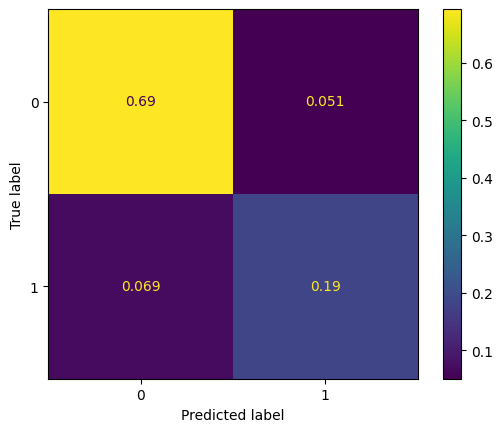

In [4]:
# Fit model on all of the training data
model = GradientBoostingClassifier()
model.fit(data.training.scale_features(), data.training.encode_labels())

# Make predictions for test data
predictions = model.predict(data.testing.scale_features())

# Calculate confusion matrix
cm = confusion_matrix(data.testing.encode_labels(), predictions)
print('\nConfusion matrix:')
print(cm)

# Normalize confusion matrix
print(f'\nNormalized confusion matrix:')

normalized_cm = cm / sum(sum(cm))
_ = ConfusionMatrixDisplay.from_estimator(
    model, 
    data.testing.scale_features(), 
    data.testing.encode_labels(), 
    normalize = 'all'
)

## Save the model

In [5]:
output_file = config.XGB_CLASSIFIER

with open(output_file, 'wb') as file:
    dump(model, file, protocol = 5)